In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Styling
plt.style.use('tdrstyle.mplstyle')

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.10/09


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  return tree

In [4]:
#maxEvents = 500000
maxEvents = 2000000

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

eta_bins = (1.2, 1.4, 1.55, 1.7, 1.8, 1.98, 2.15, 2.5)
eta_bins = eta_bins[::-1]
pt_bins = (-0.50, -0.333333, -0.25, -0.20, -0.15, -0.10, -0.05, 0.05, 0.10, 0.15, 0.20, 0.25, 0.333333, 0.50)
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)

def find_eta_bin(eta):
  ieta = np.digitize((abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def analysis(verbose=1):
  tree = load_pgun()
  
  out_pt = []
  out_phis = []

  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if verbose and (ievt % 10000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 4:
      continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
    if not has_ME1:
      continue
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    # Skip events with muon pT < 5 GeV
    #if part.pt < 5:
    #  continue
    
    # Skip events not in 1.9 < |eta| < 2.1
    if not (1.9 < abs(part.eta) < 2.1):
      continue
    
    # Find the best sector
    sector_cnt_array = np.zeros((12,), dtype=np.int32)
    sector_phi_array = np.empty((12,), dtype=np.object)
    for ind in np.ndindex(sector_phi_array.shape):
      sector_phi_array[ind] = []
    
    for ihit, hit in enumerate(evt.hits):
      #print(".. hit  {0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10} {11}".format(ihit, hit.bx, hit.type, hit.station, hit.ring, hit.sector, hit.fr, hit.sim_phi, hit.sim_theta, hit.time, hit.sim_tp1, hit.sim_tp2))
      
      phi = None
      if hit.type == kCSC and hit.sim_tp1 == 0 and hit.sim_tp2 == 0:  # only CSC hits
        if hit.station == 1 and hit.ring == 1:
          bend_corr_const = [-1.3861, 1.3692]  # ME1/1b (r,f)
          bend_corr = bend_corr_const[int(hit.fr)] * hit.bend
          bend_corr = bend_corr if hit.endcap == 1 else (bend_corr * -1)
          bend_corr = int(round(bend_corr))
          phi = (hit.station, hit.emtf_phi + bend_corr)
        elif hit.station == 1 and hit.ring == 4:
          bend_corr_const = [-1.6419, 1.6012]  # ME1/1a (r,f)
          bend_corr = bend_corr_const[int(hit.fr)] * hit.bend
          bend_corr = bend_corr if hit.endcap == 1 else (bend_corr * -1)
          bend_corr = int(round(bend_corr))
          phi = (hit.station, hit.emtf_phi + bend_corr)
        elif hit.station in (2,3,4) and hit.ring == 1:
          phi = (hit.station, hit.emtf_phi)
      
      if phi is not None:
        #assert(hit.emtf_phi < 5040)  # 84*60
        assert(phi[1] < 5040)  # 84*60
        endsec = find_endsec(hit.endcap, hit.sector)
        sector_cnt_array[endsec] += 1
        sector_phi_array[endsec].append(phi)
    
    # Get the best sector
    best_sector = np.argmax(sector_cnt_array)
    
    has_station_1 = any([phi[0] == 1 for phi in sector_phi_array[best_sector]])
    has_station_2 = any([phi[0] == 2 for phi in sector_phi_array[best_sector]])
    
    if has_station_1 and has_station_2:
      out_pt.append(part.invpt)
      out_phis.append(sector_phi_array[best_sector])
    
  return np.asarray(out_pt), np.asarray(out_phis)

In [5]:
# Run analysis

out_pt, out_phis = analysis()

[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Processing event: 0
Processing event: 10000
Processing event: 20000
Processing event: 30000
Processing event: 40000
Processing event: 50000
Processing event: 60000
Processing event: 70000
Processing event: 80000
Processing event: 90000
Processing event: 100000
Processing event: 110000
Processing event: 120000
Processing event: 130000
Processing event: 140000
Processing event: 150000
Processing event: 160000
Processing event: 170000
Processing event: 180000
Processing event: 190000
Processing event: 200000
Processing event: 210000
Processing event: 220000
Processing event: 230000
Processing event: 240000
Processing event: 250000
Processing event: 260000
Processing event: 270000
Processing event: 280000
Processing event: 290000
Processing event: 300000
Processing event: 310000
Processing event: 320000
Processing event: 330000
Processing event: 340000
Processing event: 350000
Processing event: 360000
Processing event: 370

In [6]:
print out_phis.shape, out_phis

(262555,) [list([(1, 3190), (2, 3546), (3, 3568), (4, 3566)])
 list([(1, 3875), (2, 4008), (3, 4024), (4, 4032)])
 list([(1, 4308), (1, 4321), (2, 3838), (3, 3744), (4, 3714)]) ...
 list([(1, 1951), (2, 2000), (4, 2002)])
 list([(1, 2553), (2, 2800), (3, 2880), (4, 2904)])
 list([(1, 2239), (2, 2262), (3, 2264), (4, 2264)])]


In [7]:
from six.moves import range, zip

img = np.zeros((64,64,5), dtype=np.int32)
label = np.zeros((64,100), dtype=np.float32)

for pt, phis in zip(out_pt, out_phis):
  for i, i_phi in enumerate(phis):
    i_station = int(i_phi[0])
    
    if i_station == 2:
      for j, j_phi in enumerate(phis):
        j_station = int(j_phi[0])
        
        if j_station == 1:
          for k, k_phi in enumerate(phis):
            k_station = int(k_phi[0])
            
            if k != i and k != j:
              j_dphi = j_phi[1]/16 - i_phi[1]/16 + 32
              j_dphi = np.clip(j_dphi, 0, 64-1)
              k_dphi = k_phi[1]/16 - i_phi[1]/16 + 32
              k_dphi = np.clip(k_dphi, 0, 64-1)
              
              j_pt = int(round(pt*100) + 50)
              j_pt = np.clip(j_pt, 0, 100-1)
              
              img[j_dphi, k_dphi, k_station] += 1
              label[j_dphi, j_pt] += 1

In [8]:
a, b = np.where(img[:,:,1])
print np.min(b), np.max(b)
a, b = np.where(img[:,:,2])
print np.min(b), np.max(b)
a, b = np.where(img[:,:,3])
print np.min(b), np.max(b)
a, b = np.where(img[:,:,4])
print np.min(b), np.max(b)

0 63
21 43
0 63
0 63


/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-omkpbe3/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


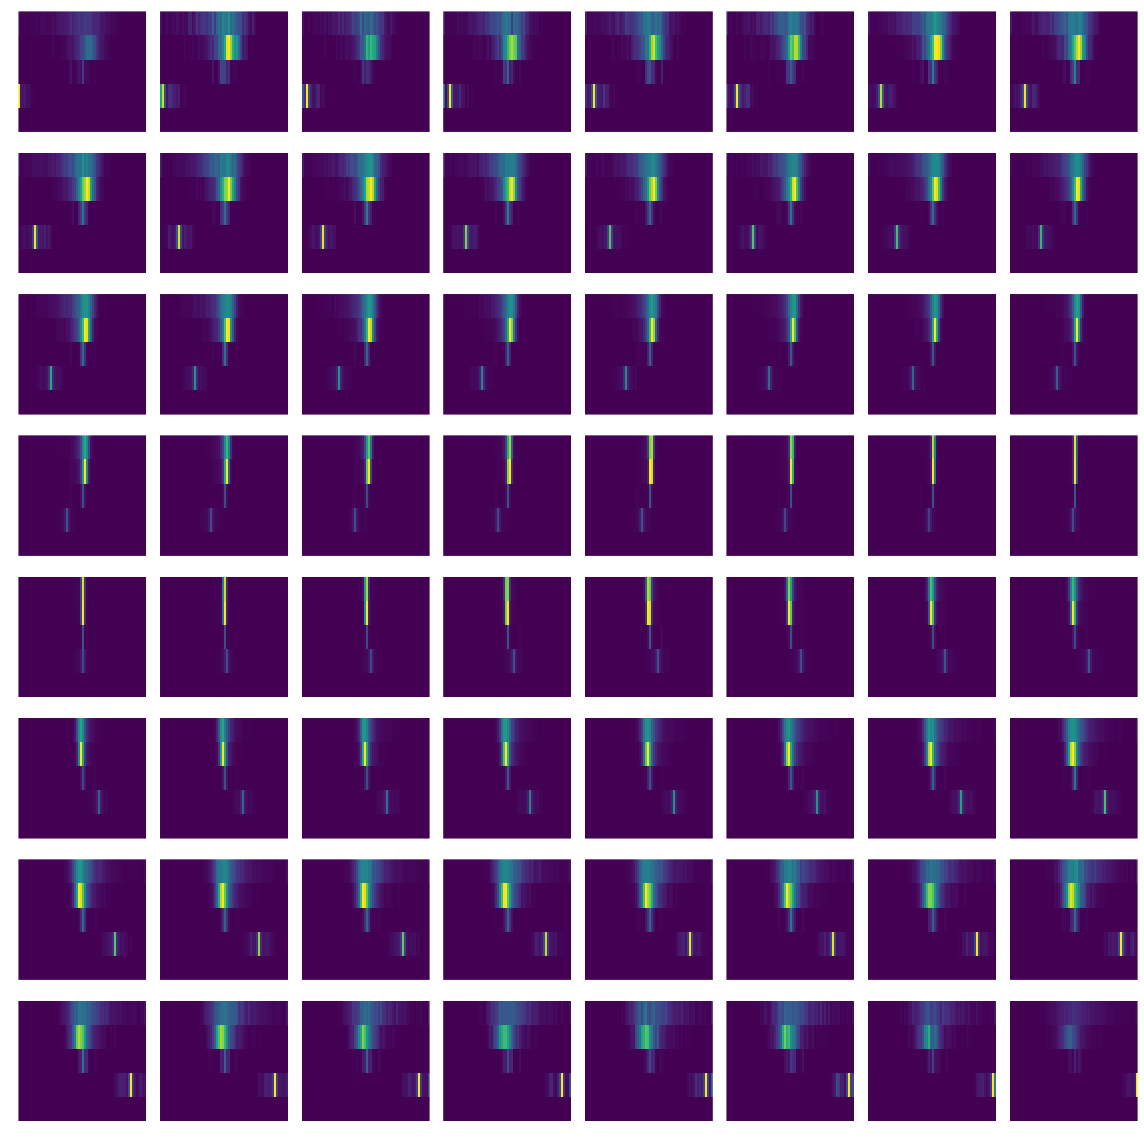

In [9]:
fig, axs = plt.subplots(64/8, 8, figsize=(2*8,2*64/8), tight_layout=True, sharex=True, sharey=True)

for i in range(64):
  test_image = img[i].T
  #print i, np.max(test_image)
  aspect = 'auto'
  extent = (0,test_image.shape[1],0,test_image.shape[0])
  axs[i/8, i%8].imshow(test_image, cmap='viridis', interpolation='none', origin='lower', extent=extent, aspect=aspect)
  axs[i/8, i%8].axis('off')

In [10]:
print img[16,16,1]

for j in range(1,5):
  a = img[16,:,j]
  b = np.true_divide(a.cumsum(), a.sum())
  c = np.searchsorted(b, 0.05, side='left')
  d = np.searchsorted(b, 0.50, side='left')
  e = np.searchsorted(b, 0.95, side='right')
  print a, c, d, e, a[c], a[d], a[e]

634
[  0   0   0   0   0   1   1   0   9   9  21  41  27  39  56 138 634 117
  58  48  42  32  15  10   6   4   0   0   0   1   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0] 11 16 21 41 634 32
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   1   7  13   1   0   0  12 145 356 137  24   5
   0   2  16   2   0   0   4   4   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0] 31 32 34 145 356 24
[   0    0    0    0    0    1    0    0    0    1    1    0    4    5
    3    5    6    5    3   14   13   27   21   20   46   43   82  112
  171  196  317  491  704 1026  991  614  286  111   24   13    5    0
    4    0    2    1    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0] 26 33 36 82 1026 286
[ 27   3   4   9   4   2  11   9   4  16  13  13  19  23  20  30  31  39
  41  46  56  8

In [11]:
data = np.zeros((64,4,2), dtype=np.int32)
for i in range(64):
  for j in range(1,5):
    a = img[i,:,j]
    b = np.true_divide(a.cumsum(), a.sum())
    percentiles = np.asarray([5])
    c = np.searchsorted(b, percentiles*0.01, side='left')
    percentiles = np.asarray([95])
    d = np.searchsorted(b, percentiles*0.01, side='right')
    data[i,j-1] = np.hstack([c,d])

  print i, data[i,2]

0 [25 41]
1 [25 40]
2 [25 39]
3 [25 39]
4 [24 39]
5 [25 39]
6 [26 38]
7 [25 38]
8 [25 38]
9 [25 38]
10 [25 38]
11 [26 38]
12 [26 37]
13 [26 37]
14 [26 36]
15 [26 36]
16 [26 36]
17 [27 36]
18 [27 36]
19 [28 35]
20 [28 35]
21 [28 35]
22 [29 35]
23 [29 35]
24 [30 34]
25 [30 34]
26 [31 34]
27 [31 34]
28 [31 33]
29 [31 33]
30 [31 33]
31 [31 33]
32 [31 33]
33 [31 33]
34 [31 33]
35 [31 33]
36 [30 33]
37 [30 33]
38 [30 33]
39 [30 34]
40 [29 34]
41 [29 34]
42 [29 35]
43 [29 36]
44 [29 36]
45 [29 37]
46 [28 37]
47 [28 37]
48 [28 37]
49 [28 38]
50 [27 38]
51 [27 38]
52 [27 38]
53 [27 38]
54 [27 38]
55 [26 38]
56 [26 38]
57 [26 38]
58 [26 38]
59 [25 38]
60 [25 39]
61 [25 38]
62 [24 38]
63 [23 38]


In [12]:
from six.moves import range, zip

data_pca_st3 = []
data_pca_st4 = []

for pt, phis in zip(out_pt, out_phis):
  for i, i_phi in enumerate(phis):
    i_station = int(i_phi[0])
    
    if i_station == 2:
      for j, j_phi in enumerate(phis):
        j_station = int(j_phi[0])
        
        if j_station == 1:
          for k, k_phi in enumerate(phis):
            k_station = int(k_phi[0])
            
            if k != i and k != j:
              j_dphi = j_phi[1]/16 - i_phi[1]/16 + 32
              j_dphi = np.clip(j_dphi, 0, 64-1)
              k_dphi = k_phi[1]/16 - i_phi[1]/16 + 32
              k_dphi = np.clip(k_dphi, 0, 64-1)

              j_pt = int(round(pt*128)) + 64
              j_pt = np.clip(j_pt, 0, 128-1)

              if k_station == 3:  
                data_pca_st3.append((j_dphi, k_dphi, j_pt))
              elif k_station == 4:
                data_pca_st4.append((j_dphi, k_dphi, j_pt))

In [13]:
# Copied from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

data_pca_st3 = np.asarray(data_pca_st3)
data_pca_st4 = np.asarray(data_pca_st4)

data_pca_st3_tmp = np.copy(data_pca_st3)
data_pca_st4_tmp = np.copy(data_pca_st4)
data_pca_st3_tmp[:,2] /= 8
data_pca_st4_tmp[:,2] /= 8

data_pca_red_st3 = PCA(n_components=2).fit_transform(data_pca_st3_tmp)
data_pca_red_st4 = PCA(n_components=2).fit_transform(data_pca_st4_tmp)

In [14]:
kmeans1 = KMeans(init='k-means++', n_clusters=15, n_init=20).fit(data_pca_red_st3)
print kmeans1.cluster_centers_, kmeans1.labels_

kmeans2 = KMeans(init='k-means++', n_clusters=11, n_init=20).fit(data_pca_red_st3)
print kmeans2.cluster_centers_, kmeans2.labels_

kmeans3 = KMeans(init='k-means++', n_clusters=9, n_init=20).fit(data_pca_red_st3)
print kmeans3.cluster_centers_, kmeans3.labels_

[[ -2.71378161   0.1756189 ]
 [ 21.26790109  -1.01758614]
 [-22.33677105   0.61791946]
 [  5.81839572  -0.28875352]
 [-11.83230547   0.182201  ]
 [ 15.95950519   7.3091781 ]
 [-29.17349822   1.14750064]
 [ 10.49132436  -0.39529569]
 [ -7.17892052   0.34701666]
 [ 15.57808245  -0.64735702]
 [ 29.07845788  -2.26677094]
 [  1.51345458  -0.09035912]
 [ 25.5041389    5.38441257]
 [-19.03328901  -8.04874647]
 [-16.73190908   0.54762612]] [ 1  7  6 ...  9  9 11]
[[-13.09436793   0.29439516]
 [ 12.00388058  -0.26476151]
 [ 27.68099496  -1.04496758]
 [ -0.57711736   0.04711308]
 [-27.96714989   0.91587214]
 [-18.90995028  -7.68338913]
 [ 19.4523186    7.47254633]
 [  5.67376136  -0.27421822]
 [ -6.90414994   0.29503313]
 [ 18.89206107  -0.84646045]
 [-19.77498477   0.74798475]] [9 7 4 ... 9 9 3]
[[ -4.09634292   0.24318244]
 [ 16.84255221  -0.68211787]
 [-18.52959434  -0.69799571]
 [  9.390593    -0.26353996]
 [-27.11709131   0.58044994]
 [ 19.76761514   7.15265144]
 [  2.50957937  -0.13999804]

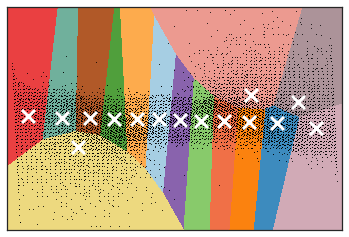

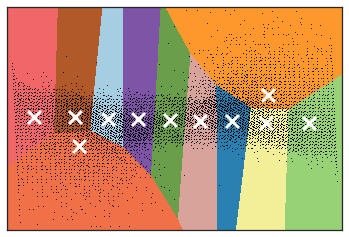

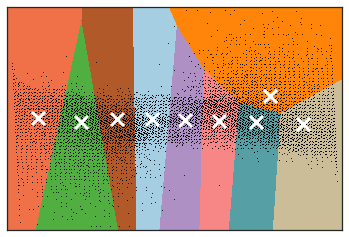

In [15]:
reduced_data = data_pca_red_st3

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z1 = kmeans1.predict(np.c_[xx.ravel(), yy.ravel()])
Z2 = kmeans2.predict(np.c_[xx.ravel(), yy.ravel()])
Z3 = kmeans3.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z1 = Z1.reshape(xx.shape)
Z2 = Z2.reshape(xx.shape)
Z3 = Z3.reshape(xx.shape)

plt.figure()
plt.imshow(Z1, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans1.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.figure()
plt.imshow(Z2, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans2.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.figure()
plt.imshow(Z3, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans3.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.show()

In [22]:
data_pca_kmeans_st3 = kmeans2.predict(data_pca_red_st3)
data_pca_kmeans_st3 = data_pca_kmeans_st3[:, np.newaxis]

#rearrange = [0,6,9,2,7,5,3,1,8,10,4]
rearrange = [7,3,1,5,9,10,0,4,6,2,8]
rearrange_f = lambda x: rearrange[x[0]]
data_pca_kmeans_st3 = np.apply_along_axis(rearrange_f, 1, data_pca_kmeans_st3)
data_pca_kmeans_st3 = data_pca_kmeans_st3[:, np.newaxis]

data_pca_st3_1 = np.hstack([data_pca_st3, data_pca_red_st3, data_pca_kmeans_st3])
print data_pca_st3.shape, data_pca_red_st3.shape, data_pca_kmeans_st3.shape, data_pca_st3_1.shape

(316727, 3) (316727, 2) (316727, 1) (316727, 6)


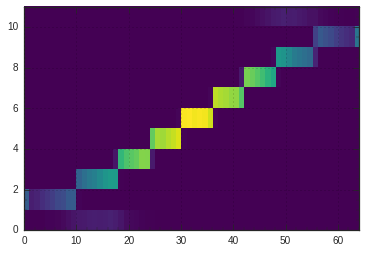

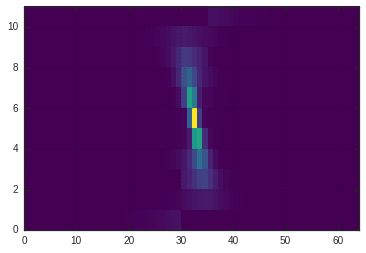

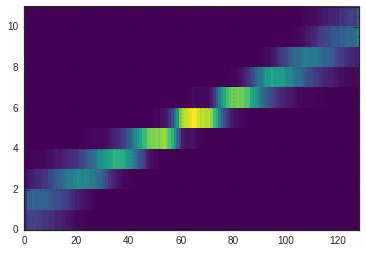

In [23]:
plt.figure()
plt.hist2d(data_pca_st3_1[:,0]+0.5, data_pca_st3_1[:,5]+0.5, bins=(np.arange(64+1), np.arange(11+1)))
plt.figure()
plt.hist2d(data_pca_st3_1[:,1]+0.5, data_pca_st3_1[:,5]+0.5, bins=(np.arange(64+1), np.arange(11+1)))
plt.figure()
plt.hist2d(data_pca_st3_1[:,2]+0.5, data_pca_st3_1[:,5]+0.5, bins=(np.arange(128+1), np.arange(11+1)))
plt.show()

In [24]:
hist, xedges, yedges = np.histogram2d(data_pca_st3_1[:,2]+0.5, data_pca_st3_1[:,5]+0.5, bins=(np.arange(128+1), np.arange(11+1)))
for i in range(11):
  b = hist[:,i].cumsum() / hist[:,i].sum()
  c = np.interp(0.10, b, np.arange(len(b))+0.5) * 100./128
  d = np.interp(0.50, b, np.arange(len(b))+0.5) * 100./128
  e = np.interp(0.90, b, np.arange(len(b))+0.5) * 100./128
  print "(%.2f, %.2f, %.2f) %i" % (c,d,e,int(e-c))

(1.00, 5.25, 12.86) 11
(1.36, 6.64, 14.16) 12
(7.02, 15.77, 23.22) 16
(15.88, 25.86, 32.74) 16
(30.95, 38.44, 44.14) 13
(45.78, 51.25, 57.32) 11
(58.57, 64.52, 72.78) 14
(69.11, 76.22, 86.15) 17
(77.83, 85.41, 93.98) 16
(86.70, 93.87, 98.77) 12
(87.49, 94.89, 99.00) 11
